In [2]:
import numpy as np
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.stats import sigma_clipped_stats
from extinction import apply, remove
from extinction import fitzpatrick99 as f99
from extinction import calzetti00 as c00
from scipy.interpolate import interp1d
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pyneb as pn
import emcee
import re

def cargar_datos(nombre_fits, nombre_fits_error):
    with fits.open(nombre_fits) as hdu:
        data = hdu[0].data
        data[np.isnan(data)] = 0
    with fits.open(nombre_fits_error) as hdu:
        data_error = hdu[0].data
        data_error[np.isnan(data_error)] = 0
    return data, data_error

def cargar_coords(nombre_reg):
    with open(nombre_reg, "r") as f:
        lines = f.readlines()
    coordinates = []
    for line in lines:
        match = re.search(r'circle\(([\d.]+),([\d.]+),([\d.]+)\)', line)
        if match:
            x, y, r = map(float, match.groups())
            if r > 0:
                coordinates.append((x, y, r))
    return coordinates


def calcular_flux(data, data_error, coordinates):
    fluxes = []
    fluxes_errors = []
    for x, y, r in coordinates:
        aperture = CircularAperture((x, y), r=r)
        annulus = CircularAnnulus((x, y), r_in=r+1.5, r_out=r+2.5)
        phot_table = aperture_photometry(data, [aperture, annulus])
        flux_total = phot_table["aperture_sum_0"][0]
        
        phot_table_err = aperture_photometry(data_error**2, [aperture, annulus])
        flux_error_total = np.sqrt(phot_table_err["aperture_sum_0"][0])
    
        annulus_mask = annulus.to_mask(method="center")
        annulus_data = annulus_mask.multiply(data)  
        annulus_data = annulus_data[annulus_mask.data > 0]  
        
        annulus_data_error = annulus_mask.multiply(data_error)  
        annulus_data_error = annulus_data_error[annulus_mask.data > 0]  

        _, median_bkg, _ = sigma_clipped_stats(annulus_data)  
        _, _, std_bkg_error = sigma_clipped_stats(annulus_data_error)
        
        area_ap = aperture.area
        
        flux_bkg = median_bkg*area_ap 
        flux_bkg_error = std_bkg_error*area_ap  
        
        flux_net = flux_total - flux_bkg
        flux_net_error = np.sqrt(flux_error_total**2 + flux_bkg_error**2)

        fluxes.append(flux_net)
        fluxes_errors.append(flux_net_error)
        
    return np.array(fluxes), np.array(fluxes_errors)


In [3]:
reg_file = "reg/NGC5068_coords_edit.reg"

file_Ha = "slices/NGC5068_MAPS_copt_0.92asec_Ha.fits"                     # Ha (6562)
file_error_Ha = "slices/NGC5068_MAPS_copt_0.92asec_Ha_error.fits"         

file_Hb = "slices/NGC5068_MAPS_copt_0.92asec_Hb.fits"                     # Hb (4861)
file_error_Hb = "slices/NGC5068_MAPS_copt_0.92asec_Hb_error.fits"

file_OIII = "slices/NGC5068_MAPS_copt_0.92asec_OIII5006.fits"               # OIII (5006)
file_error_OIII = "slices/NGC5068_MAPS_copt_0.92asec_OIII5006_error.fits"

file_NIIa = "slices/NGC5068_MAPS_copt_0.92asec_NII6583.fits"               # NII (6583)*
file_error_NIIa = "slices/NGC5068_MAPS_copt_0.92asec_NII6583_error.fits"

file_NIIb = "slices/NGC5068_MAPS_copt_0.92asec_NII6548.fits"               # NII (6548)
file_error_NIIb = "slices/NGC5068_MAPS_copt_0.92asec_NII6548_error.fits"

file_SIIa = "slices/NGC5068_MAPS_copt_0.92asec_SII6716.fits"                   # SII (6716)
file_error_SIIa = "slices/NGC5068_MAPS_copt_0.92asec_SII6716_error.fits"

file_SIIb = "slices/NGC5068_MAPS_copt_0.92asec_SII6730.fits"                   # SII (6730)
file_error_SIIb = "slices/NGC5068_MAPS_copt_0.92asec_SII6730_error.fits"

coords = cargar_coords(reg_file)

data_Ha, data_error_Ha = cargar_datos(file_Ha, file_error_Ha)
Ha, e_Ha = calcular_flux(data_Ha, data_error_Ha, coords)

data_Hb, data_error_Hb = cargar_datos(file_Hb, file_error_Hb)
Hb, e_Hb = calcular_flux(data_Hb, data_error_Hb, coords)

data_OIII, data_error_OIII = cargar_datos(file_OIII, file_error_OIII)
OIII, e_OIII = calcular_flux(data_OIII, data_error_OIII, coords)

data_NIIa, data_error_NIIa = cargar_datos(file_NIIa, file_error_NIIa)
NIIa, e_NIIa = calcular_flux(data_NIIa, data_error_NIIa, coords)

data_NIIb, data_error_NIIb = cargar_datos(file_NIIb, file_error_NIIb)
NIIb, e_NIIb = calcular_flux(data_NIIb, data_error_NIIb, coords)

data_SIIa, data_error_SIIa = cargar_datos(file_SIIa, file_error_SIIa)
SIIa, e_SIIa = calcular_flux(data_SIIa, data_error_SIIa, coords)

data_SIIb, data_error_SIIb = cargar_datos(file_SIIb, file_error_SIIb)
SIIb, e_SIIb = calcular_flux(data_SIIb, data_error_SIIb, coords)


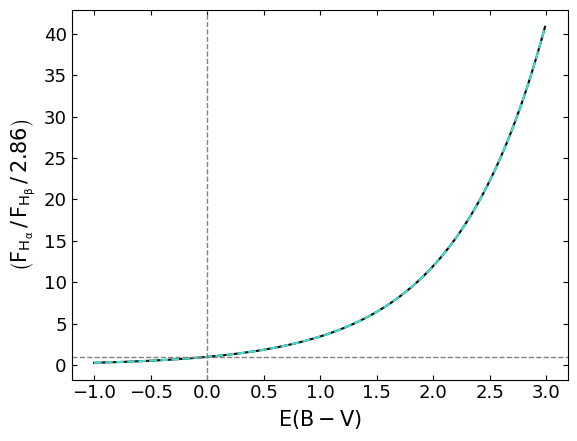

The Balmer decrement correction starts


In [5]:
x_ds, y_ds, aper = zip(*coords) 
x_ds = list(x_ds)
y_ds = list(y_ds)
aper = list(aper)

sn_Ha = []
sn_Hb = []
sn_NIIa = []
sn_NIIb = []
sn_SIIa = []
sn_SIIb = []
sn_OIII = []
for i in range(len(Ha)):
    sn_Ha.append(Ha[i]/e_Ha[i])
    sn_NIIa.append(NIIa[i]/e_NIIa[i])
    sn_NIIb.append(NIIb[i]/e_NIIb[i])
    sn_Hb.append(Hb[i]/e_Hb[i])
    sn_SIIa.append(SIIa[i]/e_SIIa[i])
    sn_SIIb.append(SIIb[i]/e_SIIb[i])
    sn_OIII.append(OIII[i]/e_OIII[i])


e_corr_Ha=[]
e_corr_Hb=[]
e_corr_OIII=[]
e_corr_NIIa=[]
e_corr_NIIb=[]
e_corr_SIIa=[]
e_corr_SIIb=[]

flux_corr_Ha=[]
flux_corr_Hb=[]
flux_corr_NIIa=[]
flux_corr_NIIb=[]
flux_corr_OIII=[]
flux_corr_SIIa=[]
flux_corr_SIIb=[]

x_ds_un = []
y_ds_un = []
Ha_un = []
Hb_un = []
NIIa_un = []
NIIb_un = []
SIIa_un = []
SIIb_un = []
OIII_un = []
aper_un = []

flux_corr_Ha_f1 = []
flux_corr_Hb_f1 = []
flux_corr_NIIa_f1 = []
flux_corr_NIIb_f1 = []
flux_corr_SIIa_f1 = []
flux_corr_SIIb_f1 = []
flux_corr_OIII_f1 = []

flux_corr_Ha_f2 = []
flux_corr_Hb_f2 = []
flux_corr_NIIa_f2 = []
flux_corr_NIIb_f2 = []
flux_corr_SIIa_f2 = []
flux_corr_SIIb_f2 = []
flux_corr_OIII_f2 = []

e_corr_Ha = []
e_corr_Hb = []
e_corr_NIIa = []
e_corr_NIIb = []
e_corr_SIIa = []
e_corr_SIIb = []
e_corr_OIII = []
e_f_corr_Ha = []
e_f_corr_Hb = []
e_f_corr_NIIa = []
e_f_corr_NIIb = []
e_f_corr_SIIa = []
e_f_corr_SIIb = []
e_f_corr_OIII = []
e_HaHb = []
EBV = []

w_min=4861
w_max=6731
def ebv_interpol(w_min, w_max):

    wave = np.array([w_min,w_max])   
    flux = [1.,2.86]
    ebv = np.array(list(range(-100,300)))*0.01
    rat = ebv*0.00000000
        
    # Por cada valor de ebv (entre -1 y 2.99) se elimnina la extincion 
    # de los valores de flujo 1 y 2.86 para Hb y Ha, respectivamente,
    # y se halla el ratio entre ellos
    
    for i in list(range(400)):
        fcor = remove(f99(wave,-3.1*ebv[i], 3.1), flux)
        rat[i] = fcor[1]/fcor[0]
        
        
    # Se crea la funcion de interpolacion entre esos valores de ebv y ratio
    inter_ratebv = interp1d(rat, ebv)
       
    # Plot de rat vs ebv y rat vs la interpolacion
       
    fig, ax = plt.subplots()
    plt.plot(ebv, rat/2.86, color = 'k', lw = 1.5);
    plt.plot(inter_ratebv(rat), rat/2.86, color = 'turquoise', lw = 1.5, ls='dashed');
    plt.xlabel(r'$\rm{E(B-V)}$', fontsize=15);
    plt.ylabel(r'$\rm{\left(F_{H_{\alpha}} \, / \, F_{H_{\beta}} \, / \, 2.86 \right)}$', fontsize=15);
    plt.xticks(fontsize=13);
    plt.yticks(fontsize=13);
    ax.get_yaxis().set_tick_params(right = True, which='both', direction='in')
    ax.get_xaxis().set_tick_params(top = True, which='both', direction='in')
    plt.axvline(0., color = 'grey', ls = '--', lw = 1.0);
    plt.axhline(1.0, color = 'grey', ls = '--', lw = 1.0);
    #plt.savefig(path_pictures+ gal_name+'_' + 'EBV_interpol.pdf')
    #plt.close()
    plt.show()

    return inter_ratebv


#-----------------------------------------------------------

#def corr_maps(w_min,w_max):
    
N=3 #Three possible values for  activity (three colors)
inter_ratebv=ebv_interpol(w_min,w_max)
#lines, e_lines, sn_lines=read_lines(f_lines)  
    

wave_Hb=np.array([4861]) 
wave_OIII=np.array([5007])
wave_Ha=np.array([6563])
wave_NIIa=np.array([6583])
wave_NIIb=np.array([6548])
wave_SIIa=np.array([6716])
wave_SIIb=np.array([6731])
    
    
    
#Read the lines and errors from the dictionary
    
#We propagate the errors of the interpolation


    
    
# We generate an array for the EBV values
    
#EBV = np.empty((len(Ha))); EBV[:] = np.nan   

print ('The Balmer decrement correction starts')

for i in range (len(Ha)):
    if sn_Ha[i]>3.0 and sn_Hb[i]>3.0 and Ha[i]!=0 and Hb[i]!=0: # guarda las fuentes para las que el S/N en Ha y Hb es > 3
        ratio_med = np.float64(Ha[i])/np.float64(Hb[i])
       
  
        if ratio_med < 2.86:
            ratio_med = 2.86
        EBV.append(inter_ratebv(ratio_med)) # it creates the EBV list. For each source theratio_med which is the Ha/Hb should be >= 2.86
       
        e_HaHb.append(np.sqrt((e_Hb[i]/Ha[i])**2.0+(Hb[i]*e_Ha[i]/(Ha[i])**2.0)**2.0))
        
        x_ds_un.append(x_ds[i]) # here x_ds and y_ds are the coordinates of each source
        y_ds_un.append(y_ds[i])
        Ha_un.append(Ha[i])
        Hb_un.append(Hb[i])
        NIIa_un.append(NIIa[i])
        NIIb_un.append(NIIb[i])
        SIIa_un.append(SIIa[i])
        SIIb_un.append(SIIb[i])
        OIII_un.append(OIII[i])
        aper_un.append(aper[i])

# Empieza la correccion de extincion
for i in range (len(Ha_un)):
		#These are the extinction corrected fluxes 
        flux_corr_Ha.append(apply(f99(wave_Ha,-3.1*EBV[i],3.1),np.float64(Ha_un[i])))
        flux_corr_Hb.append(apply(f99(wave_Hb,-3.1*EBV[i],3.1),np.float64(Hb_un[i])))
        flux_corr_NIIa.append(apply(f99(wave_NIIa,-3.1*EBV[i],3.1),np.float64(NIIa_un[i])))
        flux_corr_NIIb.append(apply(f99(wave_NIIb,-3.1*EBV[i],3.1),np.float64(NIIb_un[i])))
        flux_corr_OIII.append(apply(f99(wave_OIII,-3.1*EBV[i],3.1),np.float64(OIII_un[i])))
        flux_corr_SIIa.append(apply(f99(wave_SIIa,-3.1*EBV[i],3.1),np.float64(SIIa_un[i])))
        flux_corr_SIIb.append(apply(f99(wave_SIIb,-3.1*EBV[i],3.1),np.float64(SIIb_un[i])))


#Propagation of the errors of the interpolation 

# ----------------------------------------------------------

# ERROR AQUÍ!
# Si cambio por flux_corr_Ha[i][0] no salta error, pero el e_corr_ sale muy grande
# También no sé si es porque he definido mal la lista aper como el radio de apertura (arriba de este bloque de codigo)

# ----------------------------------------------------------
for i in range (len(Ha_un)):   
        #print(flux_corr_Ha[i])
        flux_corr_Ha_f1.append(apply(f99(wave_Ha,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_Ha[i][0])))
        flux_corr_Hb_f1.append(apply(f99(wave_Hb,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_Hb[i][0])))
        flux_corr_NIIa_f1.append(apply(f99(wave_NIIa,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_NIIa[i][0])))
        flux_corr_NIIb_f1.append(apply(f99(wave_NIIb,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_NIIb[i][0])))
        flux_corr_OIII_f1.append(apply(f99(wave_OIII,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_OIII[i][0])))
        flux_corr_SIIa_f1.append(apply(f99(wave_SIIa,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_SIIa[i][0])))
        flux_corr_SIIb_f1.append(apply(f99(wave_SIIb,-3.1*EBV[i]+e_HaHb[i],3.1),np.float64(flux_corr_SIIb[i][0])))

           
        flux_corr_Ha_f2.append(apply(f99(wave_Ha,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_Ha[i][0])))
        flux_corr_Hb_f2.append(apply(f99(wave_Hb,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_Hb[i][0])))
        flux_corr_NIIa_f2.append(apply(f99(wave_NIIa,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_NIIa[i][0])))
        flux_corr_NIIb_f2.append(apply(f99(wave_NIIb,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_NIIb[i][0])))
        flux_corr_OIII_f2.append(apply(f99(wave_OIII,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_OIII[i][0])))
        flux_corr_SIIa_f2.append(apply(f99(wave_SIIa,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_SIIa[i][0])))
        flux_corr_SIIb_f2.append(apply(f99(wave_SIIb,-3.1*EBV[i]-e_HaHb[i],3.1),np.float64(flux_corr_SIIb[i][0])))

        
        e_f_corr_Ha.append(0.5*abs(flux_corr_Ha_f2[i]-flux_corr_Ha_f1[i]))
        e_f_corr_Hb.append(0.5*abs(flux_corr_Hb_f2[i]-flux_corr_Hb_f1[i]))
        e_f_corr_NIIa.append(0.5*abs(flux_corr_NIIa_f2[i]-flux_corr_NIIa_f1[i]))
        e_f_corr_NIIb.append(0.5*abs(flux_corr_NIIb_f2[i]-flux_corr_NIIb_f1[i]))
        e_f_corr_OIII.append(0.5*abs(flux_corr_OIII_f2[i]-flux_corr_OIII_f1[i]))
        e_f_corr_SIIa.append(0.5*abs(flux_corr_SIIa_f2[i]-flux_corr_SIIa_f1[i]))
        e_f_corr_SIIb.append(0.5*abs(flux_corr_SIIb_f2[i]-flux_corr_SIIb_f1[i]))

        # Final errors. The ones we keep
        e_corr_Ha.append(np.sqrt(e_Ha[i]**2+e_f_corr_Ha[i]**2))
        e_corr_Hb.append(np.sqrt(e_Hb[i]**2+e_f_corr_Hb[i]**2))
        e_corr_OIII.append(np.sqrt(e_OIII[i]**2+e_f_corr_OIII[i]**2))
        e_corr_NIIa.append(np.sqrt(e_NIIa[i]**2+e_f_corr_NIIa[i]**2))
        e_corr_NIIb.append(np.sqrt(e_NIIb[i]**2+e_f_corr_NIIb[i]**2))
        e_corr_SIIa.append(np.sqrt(e_SIIa[i]**2+e_f_corr_SIIa[i]**2))
        e_corr_SIIb.append(np.sqrt(e_SIIb[i]**2+e_f_corr_SIIb[i]**2))

In [6]:
aper = np.array(aper)

flux_corr_SIIa = np.array(SIIa)
flux_corr_SIIb = np.array(SIIb)
flux_corr_NIIa = np.array(NIIa)
flux_corr_NIIb = np.array(NIIb)
flux_corr_OIII = np.array(OIII)
flux_corr_Ha = np.array(Ha)
flux_corr_Hb = np.array(Hb)

e_corr_SIIa = np.array(e_SIIa)
e_corr_SIIb = np.array(e_SIIb)
e_corr_NIIa = np.array(e_NIIa)
e_corr_NIIb = np.array(e_NIIb)
e_corr_OIII = np.array(e_OIII)
e_corr_Ha = np.array(e_Ha)
e_corr_Hb = np.array(e_Hb)

flux_corr_SII = flux_corr_SIIa + flux_corr_SIIb
e_corr_SII = np.sqrt(e_corr_SIIa**2 + e_corr_SIIb**2)

flux_corr_NII = flux_corr_NIIa + flux_corr_NIIb
e_corr_NII = np.sqrt(e_corr_NIIa**2 + e_corr_NIIb**2)

size = len(flux_corr_Ha)

x_snr = np.full(size, np.nan)
y_snr = np.full(size, np.nan)
Ha_snr = np.full(size, np.nan)
e_Ha_snr = np.full(size, np.nan)
Hb_snr = np.full(size, np.nan)
e_Hb_snr = np.full(size, np.nan)
SII_snr = np.full(size, np.nan)
e_SII_snr = np.full(size, np.nan)
NIIa_snr = np.full(size, np.nan)
e_NIIa_snr = np.full(size, np.nan)
OIII_snr = np.full(size, np.nan)
e_OIII_snr = np.full(size, np.nan)
diag_snr = np.full((size, 5), '', dtype=object)

In [7]:
# SII-NII diagnostic
a30 = -0.043
a21 = 0.175
a20 = -0.257
a12 = 0.029
a11 = -2.452
a10 = 2.244
a03 = -0.217
a02 = 1.388
a01 = 1.116
a00 = 2.763
f_SII_NII = lambda x, y: (a30*x**3.0 + a21*x**2.0*y + a20*x**2.0 + a12*x*y**2.0 + a11*x*y + a10*x + a03*y**3.0 + a02*y**2.0 + a01*y + a00)

for i in range(len(flux_corr_Ha)):
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_SII[i]/e_corr_SII[i]
    cond3 = flux_corr_NIIa[i]/e_corr_NIIa[i]
    if cond1>3.0 and cond2>3.0 and cond3>3.0 and flux_corr_Ha[i]!=0 and flux_corr_SII[i]!=0 and flux_corr_NIIa[i]!=0:
        ratio_SII_Ha = flux_corr_SII[i] / flux_corr_Ha[i]
        ratio_SII_Ha_error = ratio_SII_Ha * np.sqrt((e_corr_SII[i]/flux_corr_SII[i])**2 + (e_corr_Ha[i]/flux_corr_Ha[i])**2)
        ratio_NII_Ha = flux_corr_NIIa[i] / flux_corr_Ha[i]
        ratio_NII_Ha_error = ratio_NII_Ha * np.sqrt((e_corr_NIIa[i] / flux_corr_NIIa[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2)
        cond4 = ratio_SII_Ha / ratio_SII_Ha_error
        cond5 = ratio_NII_Ha / ratio_NII_Ha_error
        if cond4>3.0 and cond5>3.0 and ratio_SII_Ha!=0 and ratio_NII_Ha!=0:
            if f_SII_NII(np.log10(ratio_SII_Ha),np.log10(ratio_NII_Ha))>0:
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][0]='SII-NII'
        

In [8]:
# NII-OIII diagnostic
a10 = 0.939
a01 = 1.000
a00 = 0.469                         
f_NII_OIII = lambda x, y: (a10*x + a01*y + a00)


for i in range(len(flux_corr_Ha)):
    cond0 = flux_corr_Hb[i]/e_corr_Hb[i]
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_OIII[i]/e_corr_OIII[i]
    cond3 = flux_corr_NIIa[i]/e_corr_NIIa[i]
    if cond0>3.0 and cond1>3.0 and cond2>3.0 and cond3>3.0 and flux_corr_Ha[i]!=0 and flux_corr_Hb[i]!=0 and flux_corr_OIII[i]!=0 and flux_corr_NIIa[i]!=0:
        ratio_OIII_Hb = flux_corr_OIII[i] / flux_corr_Hb[i]
        ratio_OIII_Hb_error = ratio_OIII_Hb * np.sqrt((e_corr_OIII[i]/flux_corr_OIII[i])**2 + (e_corr_Hb[i]/flux_corr_Hb[i])**2)
        ratio_NII_Ha = flux_corr_NIIa[i] / flux_corr_Ha[i]
        ratio_NII_Ha_error = ratio_NII_Ha * np.sqrt((e_corr_NIIa[i] / flux_corr_NIIa[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2)
        cond4 = ratio_OIII_Hb / ratio_OIII_Hb_error
        cond5 = ratio_NII_Ha / ratio_NII_Ha_error
        if cond4>3.0 and cond5>3.0 and ratio_OIII_Hb!=0 and ratio_NII_Ha!=0:
            if f_NII_OIII(np.log10(ratio_NII_Ha),np.log10(ratio_OIII_Hb))>0:
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][1]='NII-OIII'

In [9]:
# SII-OIII diagnostic
a30 = 0.079
a21 = 0.148
a20 = -1.821
a12 = -0.318
a11 = -0.781
a10 = 4.66
a03 = 0.255
a02 = -0.479
a01 = 4.433
a00 = 3.403
f_SII_OIII = lambda x, y: (a30*x**3.0 + a21*x**2.0*y + a20*x**2.0 + a12*x*y**2.0 + a11*x*y + 
                           a10*x + a03*y**3.0 + a02*y**2.0 + a01*y + a00)


for i in range(len(flux_corr_Ha)):
    cond0 = flux_corr_Hb[i]/e_corr_Hb[i]
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_OIII[i]/e_corr_OIII[i]
    cond3 = flux_corr_SII[i]/e_corr_SII[i]  
    if cond0>3.0 and cond1>3.0 and cond2>3.0 and cond3>3.0 and flux_corr_Ha[i]!=0 and flux_corr_Hb[i]!=0 and flux_corr_OIII[i]!=0 and flux_corr_SII[i]!=0:  
        ratio_OIII_Hb = flux_corr_OIII[i] / flux_corr_Hb[i]
        ratio_OIII_Hb_error = ratio_OIII_Hb * np.sqrt((e_corr_OIII[i]/flux_corr_OIII[i])**2 + (e_corr_Hb[i]/flux_corr_Hb[i])**2)
        ratio_SII_Ha = flux_corr_SII[i] / flux_corr_Ha[i]  
        ratio_SII_Ha_error = ratio_SII_Ha * np.sqrt((e_corr_SII[i] / flux_corr_SII[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2) 
        cond4 = ratio_OIII_Hb / ratio_OIII_Hb_error
        cond5 = ratio_SII_Ha / ratio_SII_Ha_error  
        if cond4>3.0 and cond5>3.0 and ratio_OIII_Hb!=0 and ratio_SII_Ha!=0:  #
            if f_SII_OIII(np.log10(ratio_SII_Ha), np.log10(ratio_OIII_Hb))>0:  
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][2]='SII-OIII'


In [10]:
# NII-SII-OIII diagnostic
a300 = -2.913
a201 = -0.638
a210 = 1.568
a200 = 0.407
a102 = -0.866
a111 = -2.264
a101 = 1.508
a120 = 1.753
a110 = -6.913
a100 = 0.001
a003 = 1.463
a012 = -1.325
a002 = -2.732
a021 = 1.823
a011 = -2.697
a001 = 4.377
a030 = -1.585
a020 = 0.770
a010 = 1.267
a000 = 2.413                        
f_NII_SII_OIII = lambda x, y, z:(a300*x**3 + a201*x**2*z + a210*x**2*y + a200*x**2 + a102*x*z**2 + a111*x*y*z + 
                                 a101*x*z + a120*x*y**2 + a110*x*y + a100*x + a003*z**3 + a012*y*z**2 + 
                                 a002*z**2 + a021*y**2*z + a011*y*z + a001*z + a030*y**3 + a020*x*y**2+  
                                 a010*y + a000)


for i in range(len(flux_corr_Ha)):
    cond0 = flux_corr_Hb[i]/e_corr_Hb[i]
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_OIII[i]/e_corr_OIII[i]
    cond3 = flux_corr_SII[i]/e_corr_SII[i]  
    cond4 = flux_corr_NIIa[i]/e_corr_NIIa[i]
    if cond0>3.0 and cond1>3.0 and cond2>3.0 and cond3>3.0 and cond4>3.0 and flux_corr_Ha[i]!=0 and flux_corr_Hb[i]!=0 and flux_corr_OIII[i]!=0 and flux_corr_SII[i]!=0 and flux_corr_NII[i]!=0:  
        ratio_OIII_Hb = flux_corr_OIII[i] / flux_corr_Hb[i]
        ratio_OIII_Hb_error = ratio_OIII_Hb * np.sqrt((e_corr_OIII[i]/flux_corr_OIII[i])**2 + (e_corr_Hb[i]/flux_corr_Hb[i])**2)
        ratio_SII_Ha = flux_corr_SII[i] / flux_corr_Ha[i]  
        ratio_SII_Ha_error = ratio_SII_Ha * np.sqrt((e_corr_SII[i] / flux_corr_SII[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2)  
        ratio_NII_Ha = flux_corr_NIIa[i] / flux_corr_Ha[i]
        ratio_NII_Ha_error = ratio_NII_Ha * np.sqrt((e_corr_NIIa[i] / flux_corr_NIIa[i])**2 + (e_corr_Ha[i] / flux_corr_Ha[i])**2)
        cond5 = ratio_OIII_Hb / ratio_OIII_Hb_error
        cond6 = ratio_SII_Ha / ratio_SII_Ha_error  
        cond7 = ratio_NII_Ha / ratio_NII_Ha_error
        if cond5>3.0 and cond6>3.0 and cond7>3.0 and ratio_OIII_Hb!=0 and ratio_SII_Ha!=0 and ratio_NII_Ha!=0:  #
            if f_NII_SII_OIII(np.log10(ratio_NII_Ha), np.log10(ratio_SII_Ha), np.log10(ratio_OIII_Hb))>0:  
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][3]='NII-SII-OIII'

In [11]:
# SII-Ha diagnostic antic

for i in range(len(flux_corr_Ha)):
    cond1 = flux_corr_Ha[i]/e_corr_Ha[i]
    cond2 = flux_corr_SII[i]/e_corr_SII[i]
    if cond1>3.0 and cond2>3.0 and flux_corr_Ha[i]!=0 and flux_corr_SII[i]!=0:
        ratio_SII_Ha = flux_corr_SII[i] / flux_corr_Ha[i]
        ratio_SII_Ha_error = ratio_SII_Ha * np.sqrt((e_corr_SII[i]/flux_corr_SII[i])**2 + (e_corr_Ha[i]/flux_corr_Ha[i])**2)
        cond4 = ratio_SII_Ha / ratio_SII_Ha_error
        if cond4>3.0 and ratio_SII_Ha!=0:
            if ratio_SII_Ha>0.4:
                x_snr[i] = x_ds[i]
                y_snr[i] = y_ds[i]
                Ha_snr[i] = flux_corr_Ha[i]
                e_Ha_snr[i] = e_corr_Ha[i]
                Hb_snr[i] = flux_corr_Hb[i]
                e_Hb_snr[i] = e_corr_Hb[i]
                OIII_snr[i] = flux_corr_OIII[i]
                e_OIII_snr[i] = e_corr_OIII[i]
                SII_snr[i] = flux_corr_SII[i]  
                e_SII_snr[i] = e_corr_SII[i]
                NIIa_snr[i] = flux_corr_NIIa[i]  
                e_NIIa_snr[i] = e_corr_NIIa[i]
                diag_snr[i][4]='SII-Ha'
        

In [12]:
print(len(x_snr))

1002


In [13]:
output_file = "reg/NGC5068_coords_code.reg"
output_file_1 = "reg/NGC5068_coords_code_1.reg"
output_file_2 = "reg/NGC5068_coords_code_2.reg"
output_file_3 = "reg/NGC5068_coords_code_3.reg"
output_file_4 = "reg/NGC5068_coords_code_4.reg"
output_file_5 = "reg/NGC5068_coords_code_5.reg"
output_file_idx = "reg/NGC5068_coords_code_idx.reg"

with open(output_file, "w") as f0, open(output_file_1, "w") as f1, open(output_file_2, "w") as f2, open(output_file_3, "w") as f3, open(output_file_4, "w") as f4, open(output_file_5, "w") as f5, open(output_file_idx, "w") as f6:
    
    for i in range(size):
        if not np.isnan(x_snr[i]):
            f0.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            diag=0
            for j in range(5):
                if (not diag_snr[i][j])==False:
                    diag+=1
            if diag==1:
                f1.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            elif diag==2:
                f2.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            elif diag==3:
                f3.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            elif diag==4:
                f4.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            elif diag==5:
                f5.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]})\n")
            if diag>=3:
                f6.write(f"circle({x_snr[i]},{y_snr[i]},{aper[i]+2}) # text={{{i}}}\n")

In [36]:
coords_eliminades = x_snr.copy()

for i in idx_eliminats:
    coords_eliminades[i] = np.nan
    print(x_snr[i], y_snr[i])

for i in range(size):
    if not np.isnan(x_snr[i]):
        diag=0
        for j in range(5):
            if (not diag_snr[i][j])==False:
                diag+=1
        if diag==1 or diag==2:
            coords_eliminades[i] = np.nan
        if diag==3:
            if diag_snr[i][4]=='SII-Ha':
                coords_eliminades[i] = np.nan
                

    
factor = 10**(-20)  # Factor de conversión
mask = ~np.isnan(coords_eliminades)  

x_snr_f = np.array(x_snr[mask].copy(), dtype=np.float64)
y_snr_f = np.array(y_snr[mask].copy(), dtype=np.float64)
aper_snr_f = np.array(aper[mask].copy(), dtype=np.float64)
Ha_snr_f = np.array(Ha_snr[mask].copy() * factor, dtype=np.float64)
e_Ha_snr_f = np.array(e_Ha_snr[mask].copy() * factor, dtype=np.float64)
Hb_snr_f = np.array(Hb_snr[mask].copy() * factor, dtype=np.float64)
e_Hb_snr_f = np.array(e_Hb_snr[mask].copy() * factor, dtype=np.float64)
OIII_snr_f = np.array(OIII_snr[mask].copy() * factor, dtype=np.float64)
e_OIII_snr_f = np.array(e_OIII_snr[mask].copy() * factor, dtype=np.float64)
SII_snr_f = np.array(SII_snr[mask].copy() * factor, dtype=np.float64)
e_SII_snr_f = np.array(e_SII_snr[mask].copy() * factor, dtype=np.float64)
NIIa_snr_f = np.array(NIIa_snr[mask].copy() * factor, dtype=np.float64)
e_NIIa_snr_f = np.array(e_NIIa_snr[mask].copy() * factor, dtype=np.float64)

diag_snr_f = [sublist for sublist, m in zip(diag_snr, mask) if m]
# Filtrem altres fluxos no utilitzats en els diagnostics
SIIa_snr_f = np.array(flux_corr_SIIa[mask].copy() * factor, dtype=np.float64)
e_SIIa_snr_f = np.array(e_corr_SIIa[mask].copy() * factor, dtype=np.float64)
SIIb_snr_f = np.array(flux_corr_SIIb[mask].copy() * factor, dtype=np.float64)
e_SIIb_snr_f = np.array(e_corr_SIIb[mask].copy() * factor, dtype=np.float64)

NII_snr_f = np.array(flux_corr_NII[mask].copy() * factor, dtype=np.float64)
e_NII_snr_f = np.array(e_corr_NII[mask].copy() * factor, dtype=np.float64)


# Calculem altres ratios necessaris i filtrem
rat_OIII_Hb_snr_f = OIII_snr_f / Ha_snr_f
e_rat_OIII_Hb_snr_f = rat_OIII_Hb_snr_f * np.sqrt((e_OIII_snr_f / OIII_snr_f)**2 + (e_Hb_snr_f / Hb_snr_f)**2)

rat_SII_Ha_snr_f = SII_snr_f / Ha_snr_f
e_rat_SII_Ha_snr_f = rat_SII_Ha_snr_f * np.sqrt((e_SII_snr_f / SII_snr_f)**2 + (e_Ha_snr_f / Ha_snr_f)**2)

rat_NII_Ha_snr_f = NII_snr_f / Ha_snr_f
e_rat_NII_Ha_snr_f = rat_NII_Ha_snr_f * np.sqrt((e_NII_snr_f / NII_snr_f)**2 + (e_Ha_snr_f / Ha_snr_f)**2)

rat_NIIa_Ha_snr_f = NIIa_snr_f / Ha_snr_f
e_rat_NIIa_Ha_snr_f = rat_NIIa_Ha_snr_f * np.sqrt((e_NIIa_snr_f / NIIa_snr_f)**2 + (e_Ha_snr_f / Ha_snr_f)**2)

rat_SIIa_SIIb_snr_f = SIIa_snr_f / SIIb_snr_f
e_rat_SIIa_SIIb_snr_f = rat_SIIa_SIIb_snr_f * np.sqrt((e_SIIa_snr_f / SIIa_snr_f)**2 + (e_SIIb_snr_f / SIIb_snr_f)**2)



In [15]:
print(len(x_snr_f), len(x_snr)) 

267 1002


In [28]:
for i in range(len(diag_snr_f)):
    if len(diag_snr_f[i]) == 5:
        print(f"x: {x_snr_f[i]}, y: {y_snr_f[i]}")

x: 574.57672, y: 178.35918
x: 616.24913, y: 110.71866
x: 389.8469, y: 75.1088
x: 698.2226, y: 67.0972
x: 675.1841, y: 55.666
x: 986.6986, y: 49.924
x: 971.2775, y: 56.5092
x: 864.4896, y: 53.0863
x: 530.168, y: 31.9019
x: 643.9372, y: 28.5124
x: 594.8268, y: 25.8376
x: 705.2496, y: 22.9285
x: 184.1164, y: 17.6769
x: 334.0711, y: 17.0304
x: 237.4113, y: 14.7955
x: 959.0549, y: 15.9368
x: 658.8727, y: 12.044
x: 202.286, y: 25.407
x: 616.7679, y: 17.5497
x: 574.984, y: 44.2983
x: 594.1961, y: 50.9967
x: 370.5566, y: 43.1349
x: 698.3193, y: 44.6431
x: 970.0449, y: 104.0099
x: 434.5745, y: 74.5998
x: 482.98071, y: 216.89661
x: 408.3687, y: 75.1064
x: 376.3844, y: 84.1134
x: 763.2287, y: 87.5274
x: 558.596, y: 126.6454
x: 593.8501, y: 73.2181
x: 620.4631, y: 75.9902
x: 394.7094, y: 125.8616
x: 603.8365, y: 131.2549
x: 659.3335, y: 136.3989
x: 755.1856, y: 97.9078
x: 939.0859, y: 88.4133
x: 776.4849, y: 106.146
x: 819.0112, y: 103.146
x: 420.5184, y: 90.9665
x: 693.465, y: 90.4183
x: 737.4093

In [81]:
# Funciones de MCMC
def log_likelihood_normal(theta, data):
    mu, sigma = theta
    if sigma <= 0 or np.isnan(mu) or np.isnan(sigma):
        return -np.inf
    return np.sum(stats.norm.logpdf(data, mu, sigma))

def log_likelihood_skewed(theta, data):
    mu, sigma, alpha = theta
    if sigma <= 0 or np.isnan(mu) or np.isnan(sigma) or np.isnan(alpha):
        return -np.inf
    return np.sum(stats.skewnorm.logpdf(data, alpha, mu, sigma))

def log_prior_normal(theta):
    mu, sigma = theta
    if 0 < sigma < 5 and 0 < mu < 5:
        return 0.0
    return -np.inf

def log_prior_skewed(theta):
    mu, sigma, alpha = theta
    if 0 < sigma < 5 and 0 < mu < 5 and -5 < alpha < 5:
        return 0.0
    return -np.inf

def log_probability_normal(theta, data):
    lp = log_prior_normal(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_normal(theta, data)  
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

def log_probability_skewed(theta, data):
    lp = log_prior_skewed(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_skewed(theta, data)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

# Parámetros de MCMC
n_walkers = 20
n_steps = 5000
n_dim_normal = 2  # para la distribución normal (mu, sigma)
n_dim_skewed = 3  # para la distribución sesgada (mu, sigma, alpha)


/home/pol-m-f/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


[[35.57393987  0.73146065]
 [35.64733072  0.64323027]
 [35.45696656  0.85339418]
 ...
 [35.5976597   0.61946302]
 [35.5964369   0.71522111]
 [35.61783886  0.6485947 ]]
[[35.10230637  0.71128418]
 [35.05169446  0.74964902]
 [35.07094018  0.63600193]
 ...
 [35.12457108  0.9317874 ]
 [35.07746408  0.79341912]
 [35.00960142  0.8313638 ]]
[[35.41632168  1.00755248]
 [35.43985935  0.75386424]
 [35.26874956  0.83615751]
 ...
 [35.25138132  0.84800258]
 [35.167377    0.76142891]
 [35.24123131  0.89860711]]
[[35.05622551  0.76388641]
 [35.16125299  0.77618244]
 [35.40629103  0.76160151]
 ...
 [35.32545371  0.58454927]
 [35.13621952  0.73225308]
 [35.1352721   0.80692178]]
[[35.11253905  0.83358045]
 [35.07858278  0.59655069]
 [35.11191299  0.82346216]
 ...
 [35.20563089  0.74002373]
 [34.99308709  0.67911777]
 [34.93307306  0.74690875]]


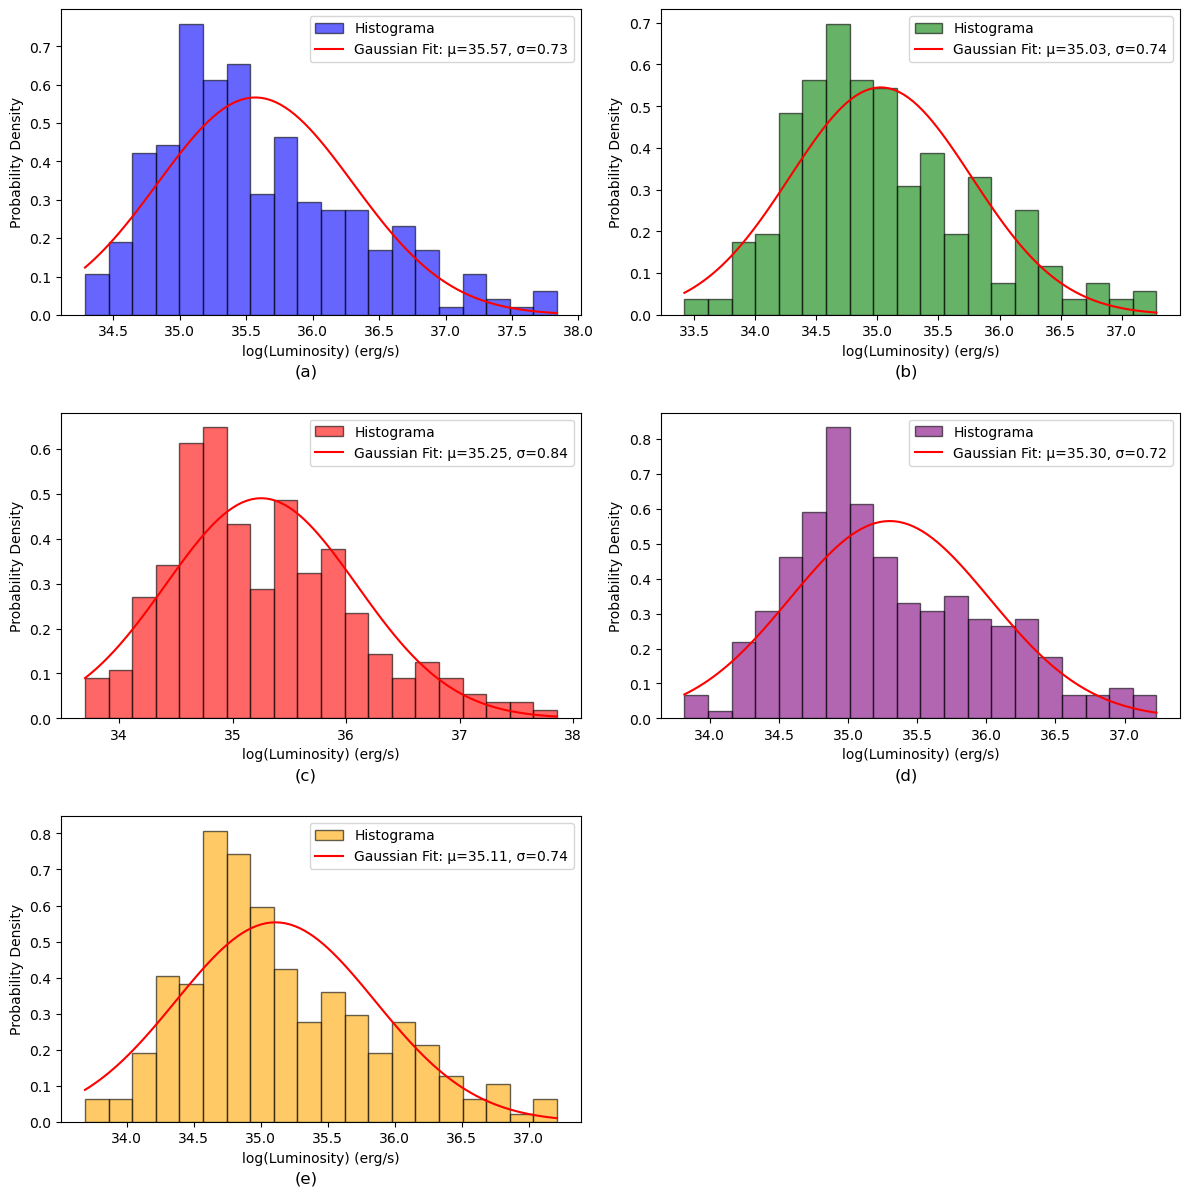

In [82]:
def luminosidad(flux, distance, flux_error, distance_error):
    # Convertir distancia a cm (si es necesario)
    distance = distance * 3.086 * 10**24
    
    # Calcular luminosidad
    L = 4 * np.pi * distance**2 * flux
    
    # Propagación de errores
    L_error = np.sqrt((4 * np.pi * distance**2 * flux_error)**2 + (8 * np.pi * distance * flux * distance_error)**2)
    
    return L, L_error

dist =  5.16 # en Mpc
e_dist = 0.35

lumi_Ha, e_lumi_Ha = luminosidad(Ha_snr_f, dist, e_Ha_snr_f, e_dist)
lumi_Hb, e_lumi_Hb = luminosidad(Hb_snr_f, dist, e_Hb_snr_f, e_dist)
lumi_OIII, e_lumi_OIII = luminosidad(OIII_snr_f, dist, e_OIII_snr_f, e_dist)
lumi_SII, e_lumi_SII = luminosidad(SII_snr_f, dist, e_SII_snr_f, e_dist)
lumi_NII, e_lumi_NII = luminosidad(NII_snr_f, dist, e_NII_snr_f, e_dist)


# --- Plot ---
plt.figure(figsize=(12, 12))

luminosities = [lumi_Ha, lumi_Hb, lumi_OIII, lumi_SII, lumi_NII]
#titles = ['Ha Luminosity', 'Hb Luminosity', '[OIII] Luminosity', '[SII] Luminosity', '[NII] Luminosity']
colors = ['blue', 'green', 'red', 'purple', 'orange']
letters = ['(a)', '(b)', '(c)', '(d)','(e)']

for idx, (lumi, letter, color) in enumerate(zip(luminosities, letters, colors), start=1):
    plt.subplot(3, 2, idx)
    
    log_lumi = np.log10(lumi)
    
    plt.hist(log_lumi, bins=20, color=color, edgecolor='black', density=True, alpha=0.6, label="Histograma")
    
    # --- Ajuste gaussiano normal usando MCMC ---
    mu_init = np.mean(log_lumi)
    sigma_init = max(np.std(log_lumi), 0.1)
    initial_positions = [np.array([mu_init, sigma_init]) + 0.1 * np.random.randn(n_dim_normal) for _ in range(n_walkers)]

    sampler = emcee.EnsembleSampler(n_walkers, n_dim_normal, log_probability_normal, args=(log_lumi,))
    sampler.run_mcmc(initial_positions, n_steps, progress=False)

    samples = sampler.get_chain(flat=True, discard=1000)
    print(samples)
    mu_mcmc, sigma_mcmc = np.median(samples, axis=0)

    x = np.linspace(min(log_lumi), max(log_lumi), 100)
    y = stats.norm.pdf(x, mu_mcmc, sigma_mcmc)

    # Normalizar la gaussiana
    area = np.trapz(y, x)
    y_scaled = y / area

    plt.plot(x, y_scaled, 'r-', label=f'Gaussian Fit: μ={mu_mcmc:.2f}, σ={sigma_mcmc:.2f}')
    #plt.title(title)
    plt.xlabel('log(Luminosity) (erg/s)')
    plt.ylabel('Probability Density')
    plt.text(0.45, -0.2, letter, transform=plt.gca().transAxes, fontsize=12)
    plt.legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.32)
plt.savefig('luminosity_NGC5068.png')
plt.show()


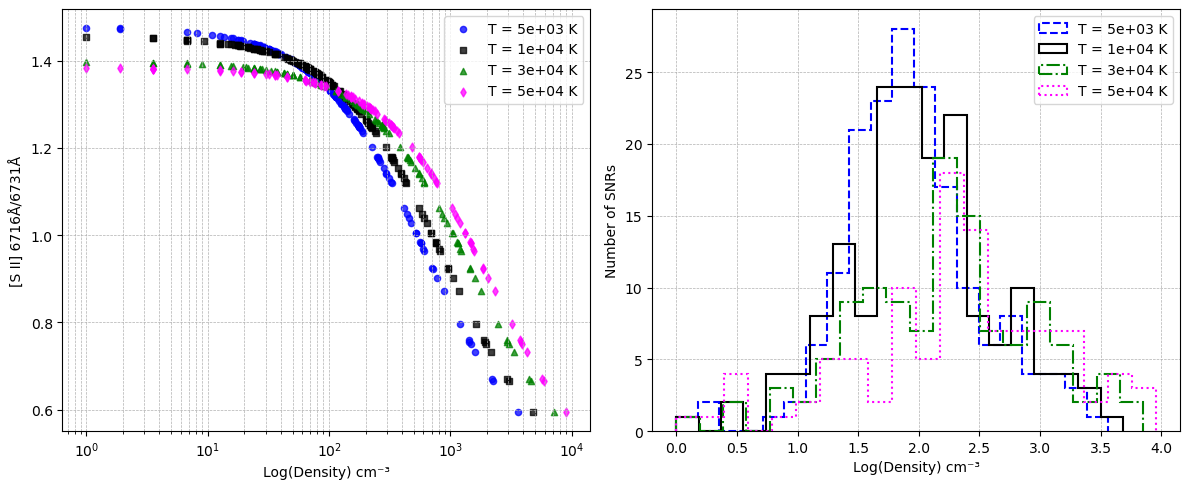

In [83]:
S2 = pn.Atom('S', 2)

temperatures = [5e3, 1e4, 3e4, 5e4]
colors = ['blue', 'black', 'green', 'magenta']
markers = ['o', 's', '^', 'd']
linestyles = ['dashed', 'solid', 'dashdot', 'dotted']
letters = ['(a)', '(b)']

# sacamos los NaNs ya que la funcion getTemDem() solo devuelve valor en un rango especifico de ratio de SII y dependiendo de la T
densities_dict = {}
rat_SIIa_SIIb_snr_dict = {}

for T in temperatures:
    densities = S2.getTemDen(rat_SIIa_SIIb_snr_f, tem=T, wave1=6716, wave2=6731)
    mask = ~np.isnan(densities)
    densities_dict[T] = densities[mask]
    rat_SIIa_SIIb_snr_dict[T] = rat_SIIa_SIIb_snr_f[mask]



fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

# Plot 1: [S II] Ratio vs Density 
for T, color, marker in zip(temperatures, colors, markers):
    axes[0].scatter(densities_dict[T], rat_SIIa_SIIb_snr_dict[T],
                    color=color, marker=marker, label=f'T = {T:.0e} K',
                    alpha=0.75, s=20)

axes[0].set_xscale('log')
axes[0].set_xlabel('Log(Density) cm⁻³')
axes[0].set_ylabel('[S II] 6716Å/6731Å')
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot 2: Density Distribution 
for T, color, linestyle in zip(temperatures, colors, linestyles):
    axes[1].hist(np.log10(densities_dict[T]), bins=20, color=color,
                 histtype='step', linestyle=linestyle, linewidth=1.5,
                 label=f'T = {T:.0e} K')

axes[1].set_xlabel('Log(Density) cm⁻³')
axes[1].set_ylabel('Number of SNRs')
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.savefig('density_plots_NGC5068.png')
plt.show()


In [84]:
ratios_que_no = []

for T in temperatures:
    print(f"Procesando T = {T}")
    ratios_1 = []
    ratios_2 = []
    
    # Identificar índices donde hay NaN en 'densities_dict[T]'
    nan_indices = np.where(np.isnan(densities_dict[T]))[0]
    print(nan_indices)
    for index in nan_indices:
        rats = rat_SIIa_SIIb_snr_dens[index]
        
        # Separar en dos listas dependiendo de si 'rats' es mayor o menor/igual a 1
        if rats > 1:
            ratios_2.append(rats)
        elif rats <= 1:
            ratios_1.append(rats)
        
        ratios_que_no.append(rats)

    # Comprobaciones antes de calcular min y max
    if ratios_1:
        print(f"Max de ratios_1: {max(ratios_1)}")
    else:
        print("ratios_1 está vacía")

    if ratios_2:
        print(f"Min de ratios_2: {min(ratios_2)}")
    else:
        print("ratios_2 está vacía")



Procesando T = 5000.0
[]
ratios_1 está vacía
ratios_2 está vacía
Procesando T = 10000.0
[]
ratios_1 está vacía
ratios_2 está vacía
Procesando T = 30000.0
[]
ratios_1 está vacía
ratios_2 está vacía
Procesando T = 50000.0
[]
ratios_1 está vacía
ratios_2 está vacía


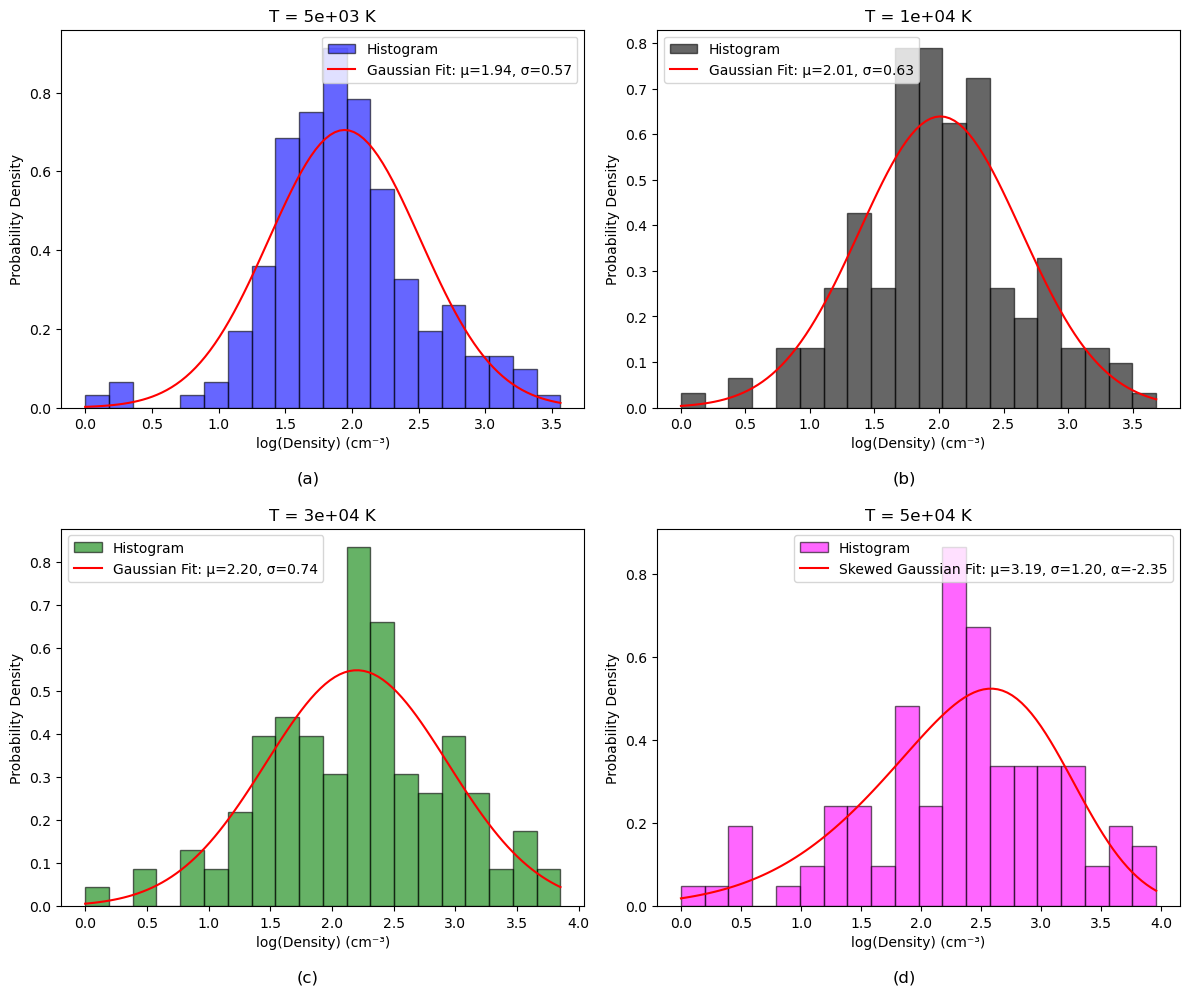

In [85]:
# Crear figura
plt.figure(figsize=(12, 10))

# Definir colores para cada temperatura
colors = ['blue', 'black', 'green', 'magenta']
letters = ['(a)', '(b)', '(c)', '(d)']

for i, T in enumerate(temperatures, 1):
    # Distribución normal en los dos primeros subgráficos
    if i <= 3:
        plt.subplot(2, 2, i)
        densities = np.log10(densities_dict[T])  # Convertir a escala logarítmica
        
        if np.any(np.isnan(densities)) or np.any(np.isinf(densities)):
            raise ValueError(f"Data for T = {T} K contains NaN or Inf values!")

        # Histograma con color diferente según temperatura
        plt.hist(densities, bins=20, density=True, alpha=0.6, color=colors[i-1], edgecolor='black', label="Histogram")
        
        # Inicialización de MCMC
        mu_init = np.mean(densities)
        sigma_init = max(np.std(densities), 0.1)
        initial_positions = [np.array([mu_init, sigma_init]) + 0.1 * np.random.randn(n_dim_normal) for _ in range(n_walkers)]
        
        # Ejecutar MCMC
        sampler = emcee.EnsembleSampler(n_walkers, n_dim_normal, log_probability_normal, args=(densities,))
        sampler.run_mcmc(initial_positions, n_steps, progress=False)

        # Extraer resultados
        samples = sampler.get_chain(flat=True, discard=1000)
        mu_mcmc, sigma_mcmc = np.median(samples, axis=0)
        
        # Ajuste de la gaussiana normal
        x = np.linspace(min(densities), max(densities), 100)
        y = stats.norm.pdf(x, mu_mcmc, sigma_mcmc)

        # Normalizar la gaussiana para que tenga un área total de 1
        area = np.trapz(y, x)  # Calcular el área bajo la curva
        y_scaled = y / area  # Normalizar la curva

        # Graficar la gaussiana normal escalada con color rojo
        plt.plot(x, y_scaled, 'r-', label=f"Gaussian Fit: μ={mu_mcmc:.2f}, σ={sigma_mcmc:.2f}")

        # Títulos y etiquetas
        plt.title(f"T = {T:.0e} K")
        plt.xlabel("log(Density) (cm⁻³)")
        plt.ylabel("Probability Density")
        plt.text(0.45, -0.2, letters[i-1], transform=plt.gca().transAxes, fontsize=12)
        plt.legend()

    # Distribución sesgada en los dos últimos subgráficos
    else:
        plt.subplot(2, 2, i)
        densities = np.log10(densities_dict[T])  # Convertir a escala logarítmica
        
        if np.any(np.isnan(densities)) or np.any(np.isinf(densities)):
            raise ValueError(f"Data for T = {T} K contains NaN or Inf values!")

        # Histograma con normalización de área (density=True)
        plt.hist(densities, bins=20, density=True, alpha=0.6, color=colors[i-1], edgecolor='black', label="Histogram")
        
        # Inicialización de MCMC
        mu_init = np.mean(densities)
        sigma_init = max(np.std(densities), 0.1)
        alpha_init = 0.0  # Inicialización de alpha (sesgo)
        initial_positions = [np.array([mu_init, sigma_init, alpha_init]) + 0.1 * np.random.randn(n_dim_skewed) for _ in range(n_walkers)]
        
        # Ejecutar MCMC
        sampler = emcee.EnsembleSampler(n_walkers, n_dim_skewed, log_probability_skewed, args=(densities,))
        sampler.run_mcmc(initial_positions, n_steps, progress=False)

        # Extraer resultados
        samples = sampler.get_chain(flat=True, discard=1000)
        mu_mcmc, sigma_mcmc, alpha_mcmc = np.median(samples, axis=0)
        
        # Ajuste de la gaussiana sesgada (skew normal)
        x = np.linspace(min(densities), max(densities), 100)
        y = stats.skewnorm.pdf(x, alpha_mcmc, mu_mcmc, sigma_mcmc)

        # Normalizar la gaussiana sesgada para que tenga un área total de 1
        area = np.trapz(y, x)  # Calcular el área bajo la curva
        y_scaled = y / area  # Normalizar la curva

        # Graficar la gaussiana sesgada escalada con color rojo
        plt.plot(x, y_scaled, 'r-', label=f"Skewed Gaussian Fit: μ={mu_mcmc:.2f}, σ={sigma_mcmc:.2f}, α={alpha_mcmc:.2f}")

        # Títulos y etiquetas
        plt.title(f"T = {T:.0e} K")
        plt.xlabel("log(Density) (cm⁻³)")
        plt.ylabel("Probability Density")
        plt.text(0.45, -0.2, letters[i-1], transform=plt.gca().transAxes, fontsize=12)
        plt.legend()


# Ajuste de espaciado entre subgráficos
plt.tight_layout()
plt.subplots_adjust(hspace=0.32)

# Guardar y mostrar la figura
plt.savefig('density_gaussian_NGC5068.png')
plt.show()


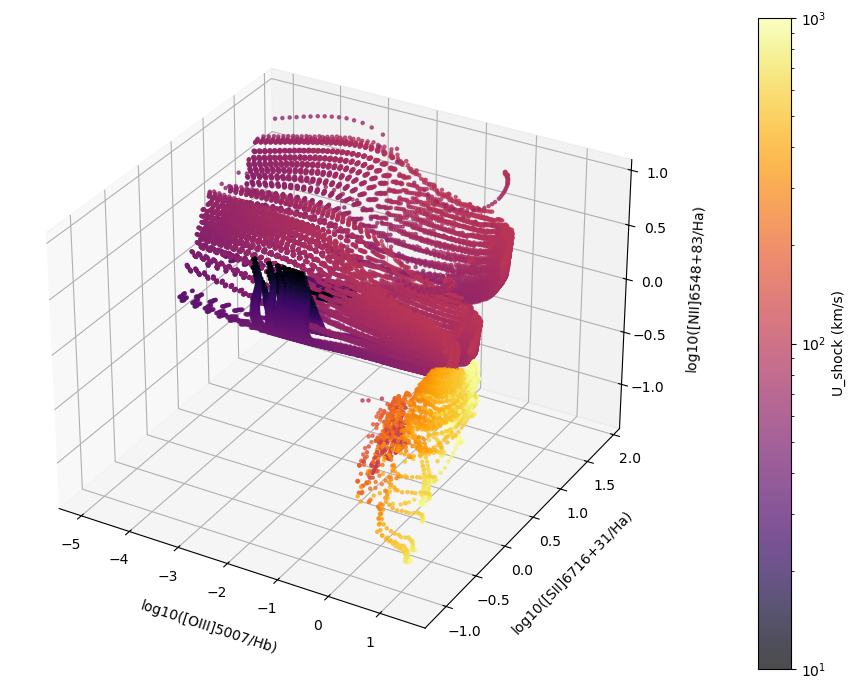

In [86]:
# Load the data
#data = np.loadtxt('shocks_OIII_SII_NII_v.txt')
data = np.loadtxt('shock_models_slow_fast_V.txt')

# Assuming the file has columns in the following order:
# log([OIII]/Hb), log([SII]/Ha), log([NII]/Ha), shock velocity
x = data[:, 0]  # log([OIII]5007/Hb)
y = data[:, 1]  # log([SII]6716+31/Ha)
z = data[:, 2]  # log([NII]6548+83/Ha)
v = data[:, 3]  # shock velocity

# Create the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


# Scatter plot with colormap
img = ax.scatter(x, y, z, c=v, cmap='inferno',norm=matplotlib.colors.LogNorm(), marker='.', alpha=0.7)

# Axis labels
ax.set_xlabel('log10([OIII]5007/Hb)', labelpad=10)
ax.set_ylabel('log10([SII]6716+31/Ha)', labelpad=10)
ax.set_zlabel('log10([NII]6548+83/Ha)', labelpad=10)

# Colorbar
cbar = fig.colorbar(img, ax=ax, pad=0.1)
cbar.set_label('U_shock (km/s)')



plt.tight_layout()
plt.show()

In [87]:
from scipy.interpolate import LinearNDInterpolator

interpolator = LinearNDInterpolator(list(zip(x, y, z)), v)

mask_log = (rat_OIII_Hb_snr_f > 0) & (rat_SII_Ha_snr_f > 0) & (rat_NII_Ha_snr_f > 0)

log_OIII_Hb = np.log10(rat_OIII_Hb_snr_f[mask_log])
log_SII_Ha = np.log10(rat_SII_Ha_snr_f[mask_log])
log_NII_Ha = np.log10(rat_NII_Ha_snr_f[mask_log])

points_to_interp = np.stack([log_OIII_Hb, log_SII_Ha, log_NII_Ha], axis=1)

vel_estimates = interpolator(points_to_interp)

print("Estimated Shock Velocities:", vel_estimates)


Estimated Shock Velocities: [159.94093713 246.44846247 137.44349583 139.9568652  138.16702886
 116.1325107   91.42905511 134.06958901 174.45064923 309.42697422
 204.06557744 103.47690087 126.94341864 291.72178434 148.90641284
 119.24472457 126.89955841 132.96754096  92.62512763 110.29169506
 117.91691987 212.81252295 198.68258096 128.13790151 135.66687345
 178.62429996 129.52354746 152.90880053 121.52814565 159.10831207
 111.76650916  93.28564488 172.69535738 122.93741644 125.47305603
 177.04371826 108.64876811 169.87761542 136.0562509  122.45083694
 263.15078631 122.24084474 136.10966712 174.96540088 176.00411189
 267.19739178 653.26885742 112.57392058 101.17344567 108.06540498
  80.07686489 141.35708774 304.6468712  168.54216298 105.05635805
 123.25268624 121.84171732 118.22188265 205.13949762 197.95862604
 116.90478862 155.04965089 178.08758797 344.74509416 270.68370549
 410.50929101 119.91278886 323.55268851 242.97066095 175.86338355
 161.8451986  103.16969795 119.64095452 101.5033

In [88]:
output_file = "reg/NGC5068_NII.reg"
output_txt = "special_ratios_NGC5068.txt"

mask_vel = ~np.isnan(vel_estimates)
indx = np.where(~mask_vel)[0]

# Obrim ambdós fitxers en mode escriptura
with open(output_file, "w") as f, open(output_txt, "w") as f_t:
    # Escriure la capçalera del fitxer de ratios
    f_t.write("x_coord\ty_coord\t[SII]/Hα\t[NII]/Hα\t[OIII]/Hβ\n")
    
    for i in indx:
        print(diag_snr_f[i])
        print(x_snr_f[i], y_snr_f[i])
        
        # Escriure coordenades i valors de ràtios
        f_t.write(f"{x_snr_f[i]:.3f}\t{y_snr_f[i]:.3f}\t{rat_SII_Ha_snr_f[i]:.3f}\t{rat_NIIa_Ha_snr_f[i]:.3f}\t{rat_OIII_Hb_snr_f[i]:.3f}\n")
        
        # Escriure al fitxer .reg
        f.write(f"circle({x_snr_f[i]},{y_snr_f[i]},{aper_snr_f[i]})\n")


['' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' '']
725.0129 761.459
['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
606.8896 755.7804
['SII-NII' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' 'SII-Ha']
283.5176 728.3914
['' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' '']
133.46685 585.81614
['SII-NII' '' 'SII-OIII' 'NII-SII-OIII' '']
156.106 452.3994
['' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' '']
264.4271 315.4386
['' 'NII-OIII' 'SII-OIII' 'NII-SII-OIII' '']
860.06286 986.80713


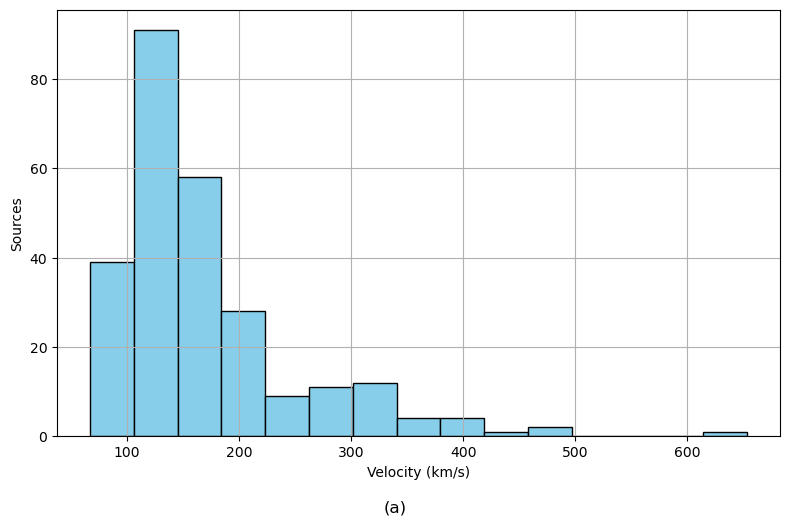

In [89]:
# Elimina valores NaN si los hay
vel_clean = vel_estimates[mask_vel]

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(vel_clean, bins=15, color='skyblue', edgecolor='black')
plt.xlabel("Velocity (km/s)")
plt.ylabel("Sources")
plt.figtext(0.5, -0.035, "(a)", ha='center', fontsize=12)


plt.grid(True)
plt.tight_layout()
plt.savefig('shock_vel_NGCNGC5068.png')
plt.show()


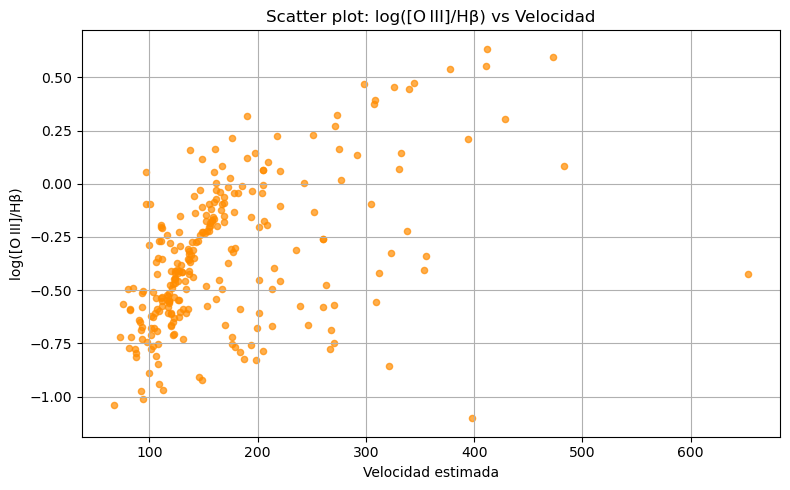

In [90]:
# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(vel_clean, log_OIII_Hb[mask_vel], s=20, alpha=0.7, c='darkorange')
plt.xlabel("Velocidad estimada")
plt.ylabel("log([O III]/Hβ)")
plt.title("Scatter plot: log([O III]/Hβ) vs Velocidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
print(len(log_OIII_Hb),len(log_NII_Ha))

267 267


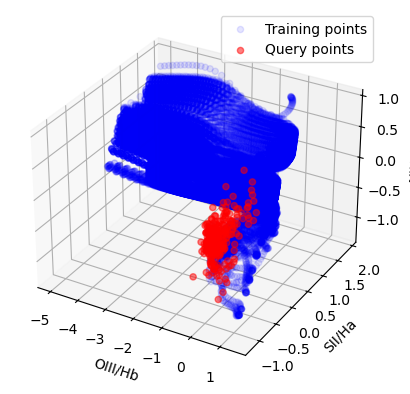

In [92]:
# Conjunt de punts que defineixen el volum d’interpolació
points_interp = np.stack([x, y, z], axis=1)

# Punts on vols estimar la velocitat
points_query = np.stack([log_OIII_Hb, log_SII_Ha, log_NII_Ha], axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Punts d’entrenament
ax.scatter(points_interp[:,0], points_interp[:,1], points_interp[:,2], color='blue', label='Training points', alpha=0.1)

# Punts a interpolar
ax.scatter(points_query[:,0], points_query[:,1], points_query[:,2], color='red', label='Query points', alpha=0.5)

ax.set_xlabel("OIII/Hb")
ax.set_ylabel("SII/Ha")
ax.set_zlabel("NII/Ha")
ax.legend()
plt.show()

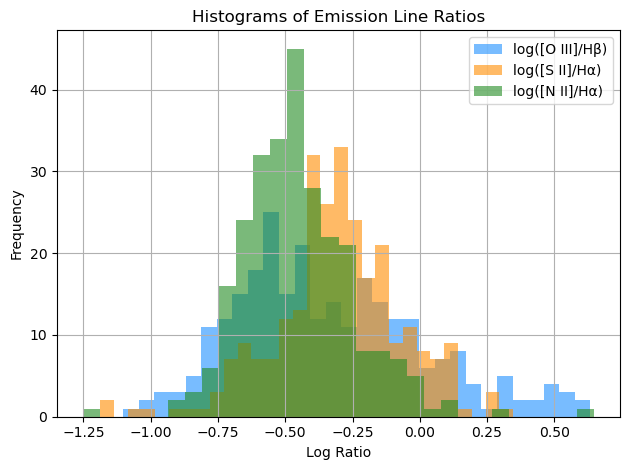

In [93]:
mask_log = (rat_OIII_Hb_snr_f > 0) & (rat_SII_Ha_snr_f > 0) & (rat_NII_Ha_snr_f > 0)

log_OIII_Hb = np.log10(rat_OIII_Hb_snr_f[mask_log])
log_SII_Ha = np.log10(rat_SII_Ha_snr_f[mask_log])
log_NII_Ha = np.log10(rat_NII_Ha_snr_f[mask_log])

# Plot histogramsplt.figure(figsize=(12, 5))

plt.hist(log_OIII_Hb, bins=30, alpha=0.6, label='log([O III]/Hβ)', color='dodgerblue')
plt.hist(log_SII_Ha, bins=30, alpha=0.6, label='log([S II]/Hα)', color='darkorange')
plt.hist(log_NII_Ha, bins=30, alpha=0.6, label='log([N II]/Hα)', color='forestgreen')

plt.xlabel('Log Ratio')
plt.ylabel('Frequency')
plt.title('Histograms of Emission Line Ratios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [94]:
### print("Longitud rat_OIII_Hb_snr_f:", len(rat_OIII_Hb_snr_f))
print("Longitud rat_SII_Ha_snr_f:", len(rat_SII_Ha_snr_f))
print("Longitud rat_NII_Ha_snr_f:", len(rat_NII_Ha_snr_f))
print("Longitud rat_NIIa_Ha_snr_f:", len(rat_NIIa_Ha_snr_f))
data = np.column_stack((rat_OIII_Hb_snr_f, rat_SII_Ha_snr_f, rat_NIIa_Ha_snr_f, rat_NII_Ha_snr_f))

np.savetxt("ratios_velocidades_NGC5068.txt", data, header="OIII_Hb SII_Ha NII(6583)_Ha NII(6583+6548)_Ha", fmt="%.6e")

Longitud rat_SII_Ha_snr_f: 267
Longitud rat_NII_Ha_snr_f: 267
Longitud rat_NIIa_Ha_snr_f: 267


In [95]:
len(vel_estimates)

267

In [96]:
densities_dict_2={}
for T in temperatures:
    densities = S2.getTemDen(rat_SIIa_SIIb_snr_f, tem=T, wave1=6716, wave2=6731)
    densities_dict_2[T] = densities

In [97]:
headers = [
    'x', 'y', 'aper', 'diag',
    'Ha', 'Hb', 'OIII', 'SII', 'NIIa', 'SIIa', 'SIIb', 'NII'
]

# Afegim 4 densitats
density_keys = list(densities_dict_2.keys())  # Ha de tenir longitud 4
density_headers = [f'dens_{T}' for T in density_keys]

headers += density_headers + ['vel']

# Obrim fitxer per escriure
with open("resultats_final_NGC5068.csv", "w") as f:
    # Escrivim la capçalera
    f.write('\t'.join(headers) + '\n')

    # Iterem per files
    for i in range(len(x_snr_f)):
        row = [
            x_snr_f[i],
            y_snr_f[i],
            aper_snr_f[i],
            diag_snr_f[i],
            Ha_snr_f[i],
            Hb_snr_f[i],
            OIII_snr_f[i],
            SII_snr_f[i],
            NIIa_snr_f[i],
            SIIa_snr_f[i],
            SIIb_snr_f[i],
            NII_snr_f[i],
        ]

        # Afegim densitats
        for T in density_keys:
            row.append(densities_dict_2[T][i])

        # Afegim velocitat
        row.append(vel_estimates[i])

        # Convertim a string i escrivim
        row_str = '\t'.join([str(val) for val in row])
        f.write(row_str + '\n')

In [98]:
count_no_SII_Ha = sum('SII-Ha' not in arr for arr in diag_snr_f)
count_SII_Ha = sum('SII-Ha' in arr for arr in diag_snr_f)
print(count_no_SII_Ha, count_SII_Ha)

print(len(diag_snr_f))

77 190
267
